---
syncID: d2d126173eeb4494a06e35aa34bd2196
title: "Compare tree height measured from the ground to a Lidar-based Canopy Height Model"
description: "Investigate the relationship between two methods for measuring canopy height"
dateCreated: 2019-5-21
authors: Claire K. Lunch
contributors: 
estimatedTime: 60 minutes
packagesLibraries: neonUtilities, raster
topics: vegetation-structure, ecosystem-structure, canopy-height-model
languagesTool: R
dataProduct: DP1.10098.001, DP3.30015.001
code1: /R/veg-structure-chm/veg_structure_and_chm.ipynb
tutorialSeries: 
urlTitle: tree-heights-veg-structure-chm
---

This data tutorial provides instruction on working with two different NEON 
data products to estimate tree height: 

* **DP3.30015.001, Ecosystem structure**, aka Canopy Height Model (CHM) 
* **DP1.10098.001, Woody plant vegetation structure**

The <a href="https://data.neonscience.org/data-product-view?dpCode=DP3.30015.001" target="_blank">CHM data</a> are derived from the Lidar point cloud data collected by the 
remote sensing platform. The <a href="https://data.neonscience.org/data-product-view?dpCode=DP1.10098.001" target="_blank">vegetation structure data</a> are collected 
by by field staff on the ground. We will be using data from the Wind River 
Experimental Forest NEON field site located in Washington state. The 
predominant vegetation there are tall evergreen conifers. 

If you are coming to this exercise after following tutorials on data 
download and formatting, and therefore already have the needed data, 
skip ahead to section 4.

<div id="ds-objectives" markdown="1">

## Things You’ll Need To Complete This Tutorial
You will need the most current version of R loaded on your computer to complete this tutorial.

### 1. Setup

Start by installing and loading packages and setting options. One of the 
packages we'll be using, `geoNEON`, is only available via GitHub, so it's 
installed using the `devtools` package. The other packages can be 
installed directly from CRAN.

In [ ]:
options(stringsAsFactors=F)

install.packages("neonUtilities")
install.packages("sp")
install.packages("raster")
install.packages("devtools")
devtools::install_github("NEONScience/NEON-geolocation/geoNEON")

library(sp)
library(raster)
library(neonUtilities)
library(geoNEON)

### 2. Vegetation structure data

Download the vegetation structure data using the `loadByProduct()` function in
the `neonUtilities` package. Inputs needed to the function are:

* `dpID`: data product ID; woody vegetation structure = DP1.10098.001
* `site`: 4-letter site code; Wind River = WREF
* `package`: basic or expanded; we'll download basic here

Refer to the <a href="https://www.neonscience.org/neonDataStackR" target="_blank">tutorial</a> 
for the `neonUtilities` package for more details if desired.

In [ ]:
veglist <- loadByProduct(dpID="DP1.10098.001", site="WREF", package="basic")

Use the `def.calc.geo.os()` function in the `geoNEON` package to get 
precise locations for the tagged plants. Refer to the package 
documentation for more details.

In [ ]:
vegmap <- def.calc.geo.os(veglist$vst_mappingandtagging, 
                          "vst_mappingandtagging")

Merge the mapped locations of individuals (the `vst_mappingandtagging` table) 
with the annual measurements of height, diameter, etc (the 
`vst_apparentindividual` table). The two tables join on `individualID`, 
the identifier for each tagged plant, but we'll include `namedLocation`, 
`domainID`, `siteID`, and `plotID` in the list of variables to merge on, to 
avoid ending up with duplicates of each of those columns. Refer to the 
variables table and to the <a href="http://data.neonscience.org/api/v0/documents/NEON_vegStructure_userGuide_vA" target="_blank">Data Product User Guide</a> 
for Woody plant vegetation structure for more 
information about the contents of each data table.

In [ ]:
veg <- merge(veglist$vst_apparentindividual, vegmap, 
             by=c("individualID","namedLocation",
                  "domainID","siteID","plotID"))

Let's see what the data look like! Make a stem map of the plants in 
plot WREF_075. Note that stemDiameter is in centimeters.

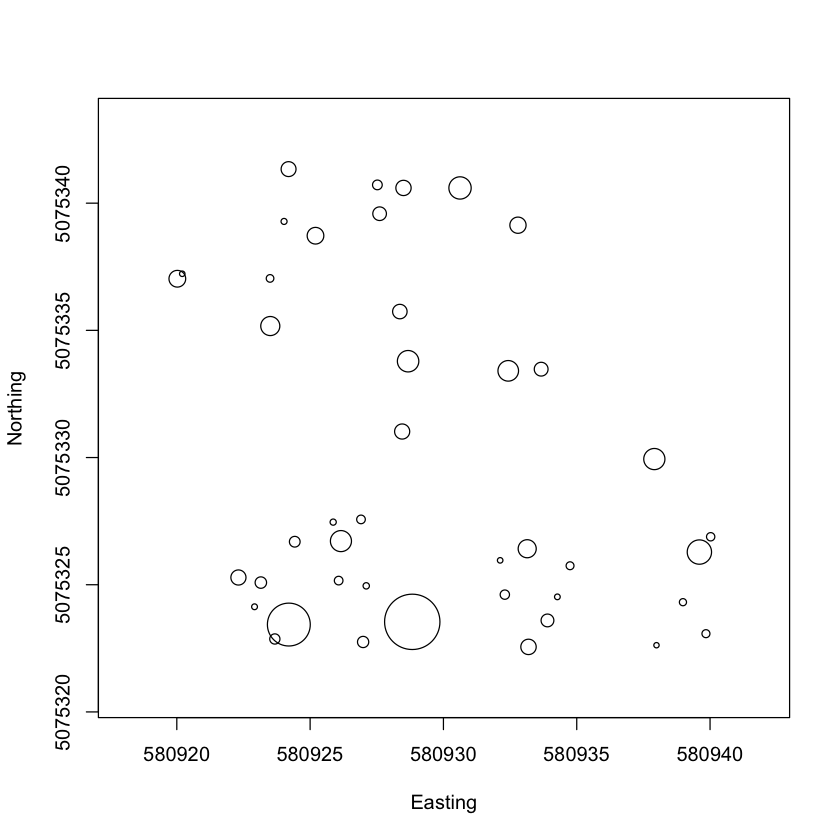

In [38]:
symbols(veg$adjEasting[which(veg$plotID=="WREF_075")], 
        veg$adjNorthing[which(veg$plotID=="WREF_075")], 
        circles=veg$stemDiameter[which(veg$plotID=="WREF_075")]/100, 
        inches=F, xlab="Easting", ylab="Northing")

And now overlay the estimated uncertainty in the location of each stem, 
in blue:

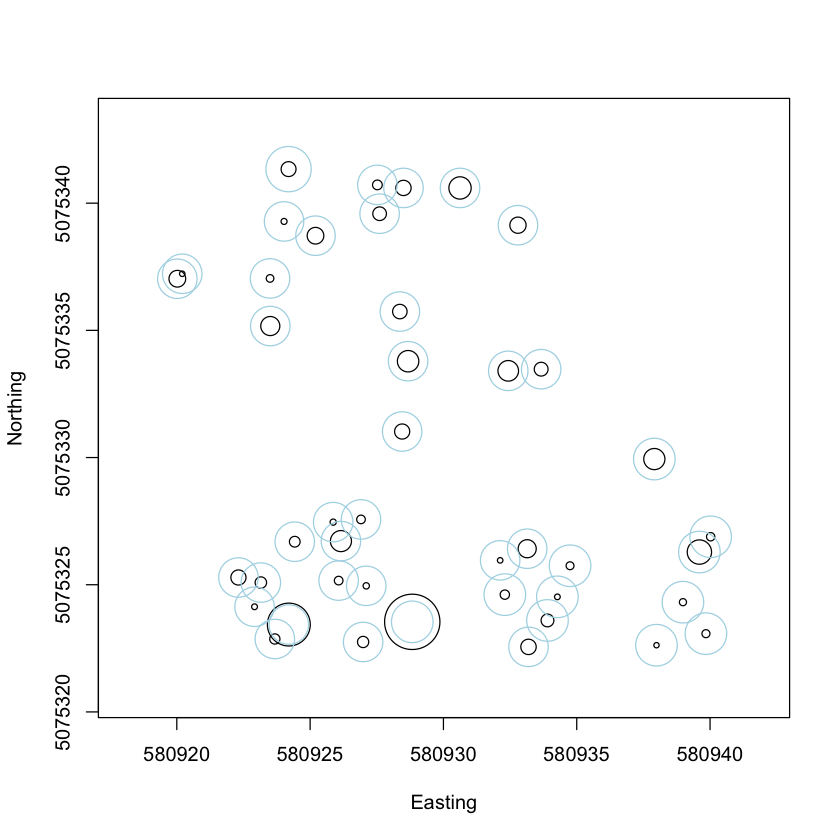

In [39]:
symbols(veg$adjEasting[which(veg$plotID=="WREF_075")], 
        veg$adjNorthing[which(veg$plotID=="WREF_075")], 
        circles=veg$stemDiameter[which(veg$plotID=="WREF_075")]/100, 
        inches=F, xlab="Easting", ylab="Northing")
symbols(veg$adjEasting[which(veg$plotID=="WREF_075")], 
        veg$adjNorthing[which(veg$plotID=="WREF_075")], 
        circles=veg$adjCoordinateUncertainty[which(veg$plotID=="WREF_075")], 
        inches=F, add=T, fg="lightblue")

### 3. Canopy height model data

Now we'll download the CHM tile corresponding to plot WREF_075. Several 
other plots are also covered by this tile. We could download all tiles 
that contain vegetation structure plots, but in this exercise we're 
sticking to one tile to limit download size and processing time.

The `tileByAOP()` function in the `neonUtilities` package allows for 
download of remote sensing tiles based on easting and northing 
coordinates, so we'll give it the coordinates of plot WREF_075 and 
the data product ID, DP3.30015.001.

The download will include several metadata files as well as the data 
tile. Load the data tile into the environment using the `raster` package.

In [ ]:
byTileAOP(dpID="DP3.30015.001", site="WREF", year="2017", 
          easting=veg$adjEasting[which(veg$plotID=="WREF_075")], 
          northing=veg$adjNorthing[which(veg$plotID=="WREF_075")],
          savepath="/data")
chm <- raster("/data/DP3.30015.001/2017/FullSite/D16/2017_WREF_1/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D16_WREF_DP3_580000_5075000_CHM.tif")

Let's view the tile.

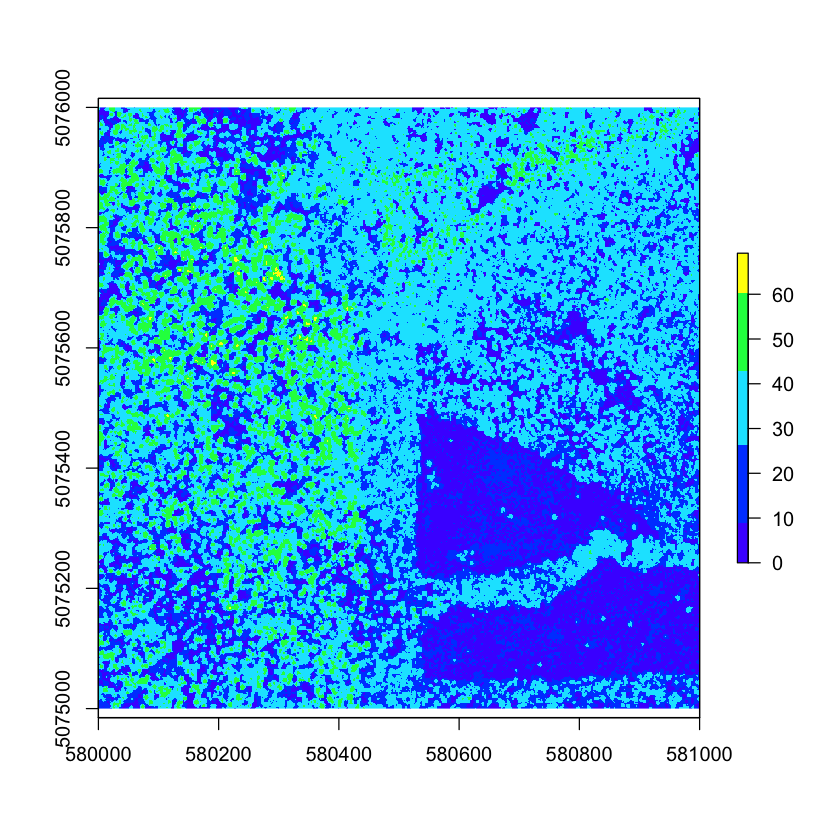

In [40]:
plot(chm, col=topo.colors(5))

### 4. Comparing the two datasets

Now we have the heights of individual trees measured from the ground, and 
the height of the top surface of the canopy, measured from the air. There 
are many different ways to make a comparison between these two 
datasets! This section will walk through three different approaches.

First, subset the vegetation structure data to only the individuals that fall 
within this tile, using the `extent()` function from the raster package.

This step isn't strictly necessary, but it will make the processing faster.

In [ ]:
vegsub <- veg[which(veg$adjEasting >= extent(chm)[1] &
                      veg$adjEasting <= extent(chm)[2] &
                      veg$adjNorthing >= extent(chm)[3] & 
                      veg$adjNorthing <= extent(chm)[4]),]

Starting with a very simple first pass: use the `extract()` function 
from the `raster` package to get the CHM value matching the coordinates 
of each mapped plant. Include a buffer equal to the uncertainty in the 
plant's location, and extract the highest CHM value within the buffer. 
Then make a scatter plot of each tree's height vs. the CHM value at its 
location.

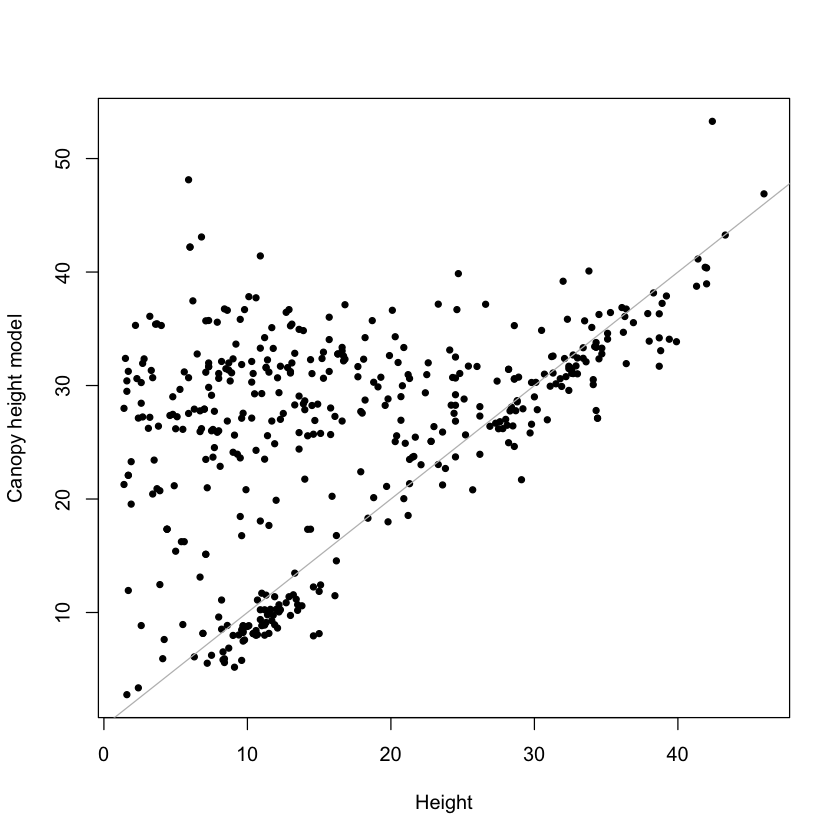

In [41]:
bufferCHM <- extract(chm, cbind(vegsub$adjEasting, 
                                vegsub$adjNorthing),
                     buffer=vegsub$adjCoordinateUncertainty, 
                     fun=max)
plot(bufferCHM~vegsub$height, pch=20, xlab="Height", 
     ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [42]:
cor(bufferCHM,vegsub$height, use="complete")

[1] 0.428952897424419

There are a lot of points clustered on the 1-1 line, but there is also a 
cloud of points above the line, where the measured height is lower than 
the canopy height model at the same coordinates. This makes sense, because 
we made no attempt to filter out the understory. There are likely many 
plants measured in the vegetation structure data that are not at the top 
of the canopy, and the CHM sees only the top surface of the canopy.

How to exclude understory plants from this analysis? Again, there are many 
possible approaches. We'll try out two, one map-centric and one 
tree-centric.

Starting with the map-centric approach: select a pixel size, and aggregate 
both the vegetation structure data and the CHM data to find the tallest point 
in each pixel. Let's try this with 10m pixels.

Start by rounding the coordinates of the vegetation structure data, to create 
10m bins. Use `floor()` instead of `round()` so each tree ends up in the pixel 
with the same numbering as the raster pixels (the rasters/pixels are 
numbered by their southwest corners).

In [ ]:
easting10 <- 10*floor(vegsub$adjEasting/10)
northing10 <- 10*floor(vegsub$adjNorthing/10)
vegsub <- cbind(vegsub, easting10, northing10)

Use the `aggregate()` function to get the tallest tree in each 10m bin.

In [ ]:
vegbin <- stats::aggregate(vegsub, by=list(vegsub$easting10, vegsub$northing10), FUN=max)

To get the CHM values for the 10m bins, use the `raster` package version 
of the `aggregate()` function. Let's take a look at the lower-resolution 
image we get as a result.

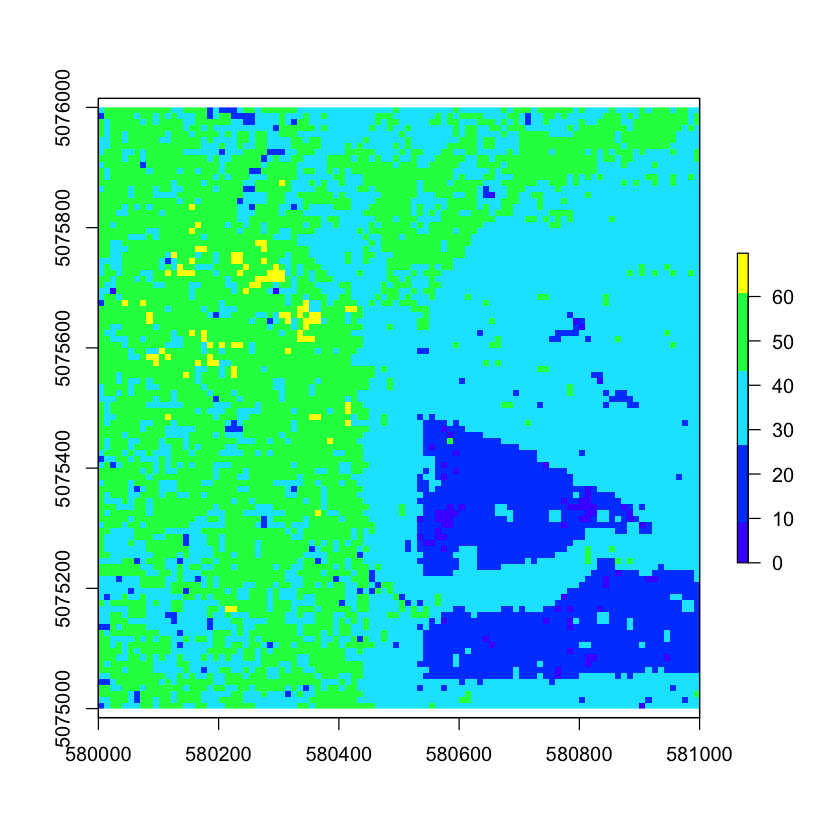

In [43]:
CHM10 <- raster::aggregate(chm, fact=10, fun=max)
plot(CHM10, col=topo.colors(5))

Use the `extract()` function again to get the values from each pixel. We 
don't need a buffer this time, since we've put both datasets onto the same 
grid. But our grids are numbered by the corners, so add 5 to each tree 
coordinate to make sure it's in the correct pixel.

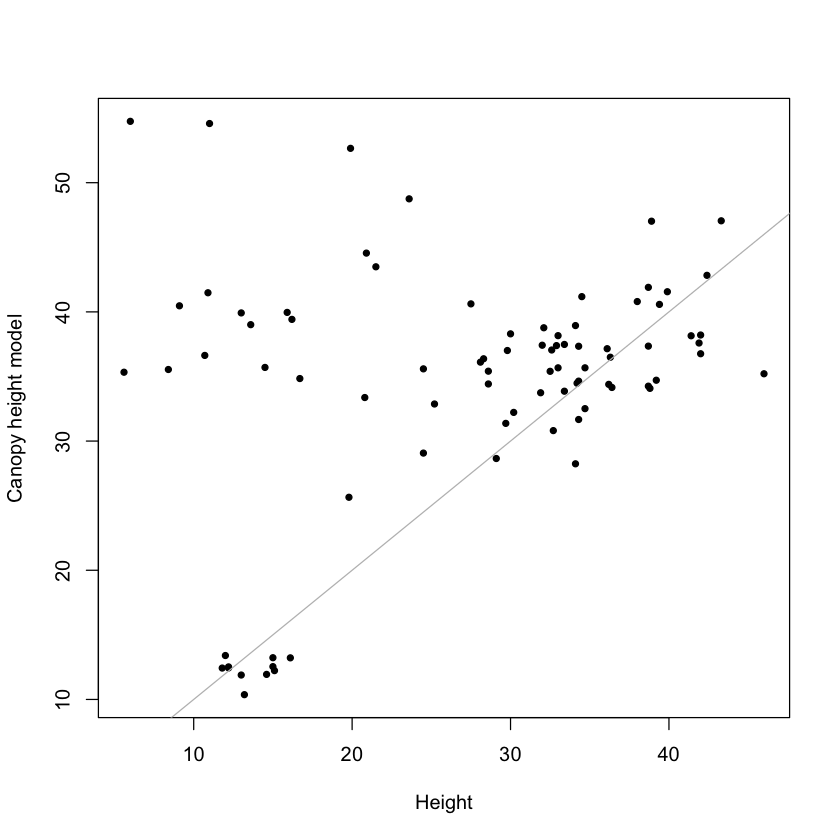

In [44]:
vegbin$easting10 <- vegbin$easting10+5
vegbin$northing10 <- vegbin$northing10+5
binCHM <- extract(CHM10, cbind(vegbin$easting10, 
                               vegbin$northing10))
plot(binCHM~vegbin$height, pch=20, 
     xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [45]:
cor(binCHM, vegbin$height, use="complete")

[1] 0.330111962496679

The understory points are thinned out substantially, but so are the rest. 
We've lost a lot of data by going to a lower resolution.

Let's try and see if we can identify the tallest trees by another approach, 
using the trees as the starting point instead of map area. Start by sorting 
the veg structure data by height.

In [ ]:
vegsub <- vegsub[order(vegsub$height, decreasing=T),]

Now, for each tree, let's estimate which nearby trees might be beneath 
its canopy, and discard those points. To do this:

1. Calculate the distance of each tree from the target tree.
2. Pick a reasonable estimate for canopy size, and discard shorter trees 
within that radius. The radius I used is 0.3 times the height, based on 
some rudimentary googling about Douglas fir allometry. It could definitely 
be improved on!
3. Iterate over all trees.

In [46]:
vegfil <- vegsub
for(i in 1:nrow(vegsub)) {
    if(is.na(vegfil$height[i]))
        next
    dist <- sqrt((vegsub$adjEasting[i]-vegsub$adjEasting)^2 + 
                (vegsub$adjNorthing[i]-vegsub$adjNorthing)^2)
    vegfil$height[which(dist<0.3*vegsub$height[i] & 
                        vegsub$height<vegsub$height[i])] <- NA
}

vegfil <- vegfil[which(!is.na(vegfil$height)),]

Now extract the raster values, as above. Let's also increase the buffer size 
a bit, to better account for the uncertainty in the Lidar data as well as 
the uncertainty in the ground locations.

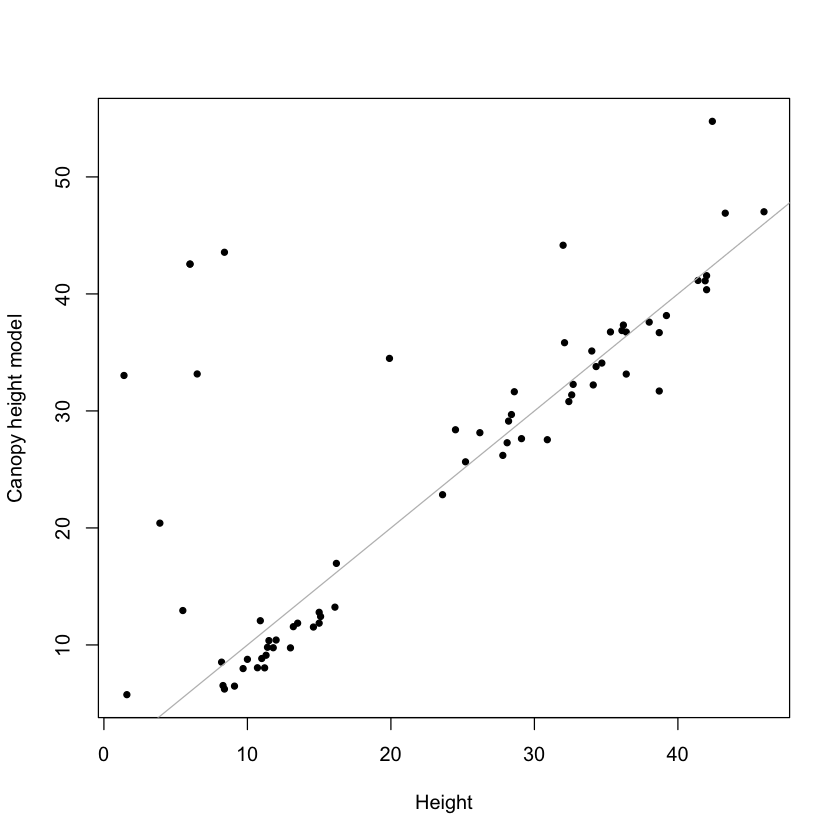

In [47]:
filterCHM <- extract(chm, cbind(vegfil$adjEasting, vegfil$adjNorthing),
                         buffer=vegfil$adjCoordinateUncertainty+1, fun=max)
plot(filterCHM~vegfil$height, pch=20, 
     xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [48]:
cor(filterCHM,vegfil$height)

[1] 0.736503668596511

This is quite a bit better! There are still several understory points we 
failed to exclude, but we were able to filter out most of the understory 
without losing so many overstory points.

Let's try one last thing. The `plantStatus` field in the veg structure data 
indicates whether a plant is dead, broken, or otherwise damaged. In theory, 
a dead or broken tree can still be the tallest thing around, but it's less 
likely, and it's also less likely to get a good Lidar return. Exclude all 
trees that aren't alive:

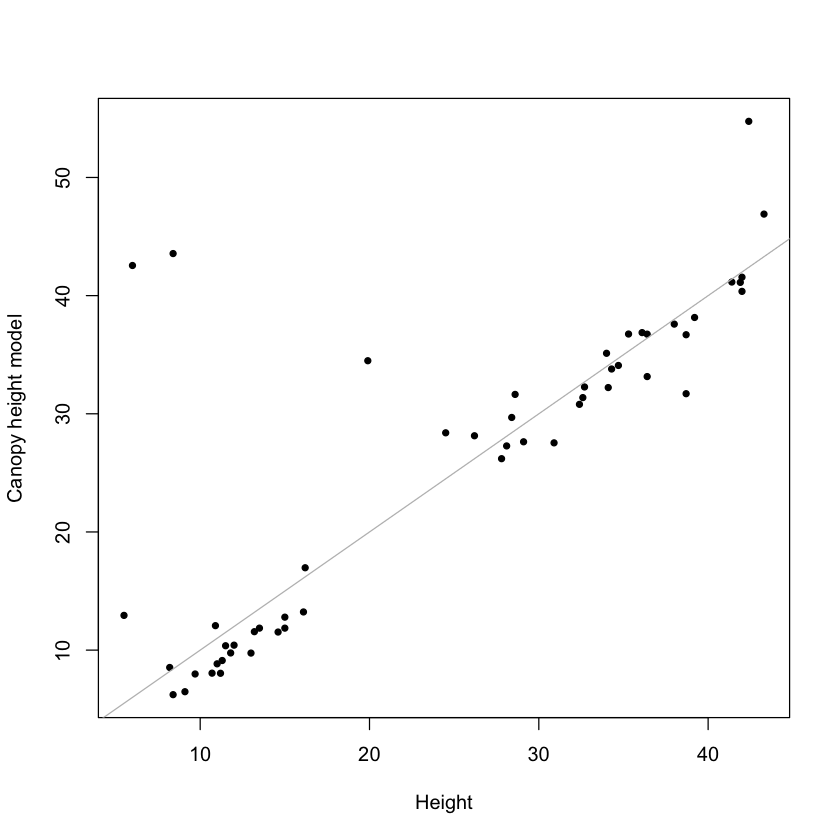

In [49]:
vegfil <- vegfil[which(vegfil$plantStatus=="Live"),]
filterCHM <- extract(chm, cbind(vegfil$adjEasting, vegfil$adjNorthing),
                         buffer=vegfil$adjCoordinateUncertainty+1, fun=max)
plot(filterCHM~vegfil$height, pch=20, 
     xlab="Height", ylab="Canopy height model")
lines(c(0,50), c(0,50), col="grey")

In [50]:
cor(filterCHM,vegfil$height)

[1] 0.819112115567101

Nice!

One final note: however we slice the data, there is a noticeable bias 
even in the strongly correlated values. The CHM heights are generally a 
bit shorter than the ground-based estimates of tree height. There are 
two biases in the CHM data that contribute to this. (1) Lidar returns 
from short-statured vegetation are difficult to distinguish from the 
ground, so the "ground" estimated by Lidar is generally a bit higher 
than the true ground surface, and (2) the height estimate from Lidar 
represents the highest return, but the highest return may slightly 
miss the actual tallest point on a given tree. This is especially 
likely to happen with conifers, which are the top-of-canopy trees at 
Wind River.